In [2]:
import numpy as np
from numpy import sin, cos, pi

from gym import core, spaces
from gym.utils import seeding

import csv
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import GenOnlyModel
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
import gc
import keras.backend

import objgraph

In [ ]:
"""
Beacon - Env 

The tree class, the main building block in the environment.
It loads an array of leaf positions and normals, and can generate an impulse response.

Tree(pos,variety,theta)
shift(pos)
checkCollision(DronePos,dronesize)
getEcho(DronePos,DroneHeading,gan)
"""
class Tree:
    def __init__(self,pos,variety,theta):
        
        # Open and load the leaf arrays
        f = open('eta'+str(variety)+'Out.csv')
        csv_reader = csv.reader(f,delimiter=',')
        
        LeafList = []
        for row in csv_reader:
            LeafList.append([float(x) for x in row])
        
        # Separate and normalize the arrays
        self.LeafArr = np.array(LeafList)
        self.pos = pos
        self.LeafPos = self.LeafArr[:,0:3]+np.array([self.pos[0],self.pos[1],0])
        self.LeafNorm = self.LeafArr[:,3:6]
        
        #Rotate the leaf array
        r_left = np.eye(3)
        # theta = np.random.choice(180)
        r_left[0:2,0:2] = np.array([[np.cos(np.deg2rad(theta)),-np.sin(np.deg2rad(theta))],[np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta))]])
        com = self.LeafPos.mean(axis=0)
        self.LeafPos = np.matmul(r_left,(self.LeafPos-com).T).T+com
        self.LeafPos[:,2] = self.LeafPos[:,2] + 25 - np.median(self.LeafPos[:,2])
        # self.LeafPos[:,2] = self.LeafPos[:,2] - self.LeafPos[:,2].min()
        
        # Knowing the max and mins can help quickly determine if the tree is in range of the drone.
        self.maxx = self.LeafPos[:,0].max()
        self.minx = self.LeafPos[:,0].min()
        self.maxy = self.LeafPos[:,1].max()
        self.miny = self.LeafPos[:,1].min()
        self.center = ((self.maxx+self.minx)/2,(self.maxy+self.miny)/2)
        self.radius = np.linalg.norm(np.array(self.center)-np.array([self.maxx,self.maxy]))
        
    
    def shift(self,pos):
        #Function to move the tree
        
        self.LeafPos = self.LeafPos + pos
        self.maxx = self.LeafPos[:,0].max()
        self.minx = self.LeafPos[:,0].min()
        self.maxy = self.LeafPos[:,1].max()
        self.miny = self.LeafPos[:,1].min()
        self.center = ((self.maxx+self.minx)/2,(self.maxy+self.miny)/2)
        
    
    def checkCollision(self,DronePos,dronesize):
        #Check if a position is within a certain radius of any leaves
        
        DroneToLeaf = self.LeafPos-DronePos
        Distances = np.linalg.norm(DroneToLeaf,axis=1)
        
        if np.where(Distances < dronesize/2)[0].size > 0:
            return True
        return False
        
    
    def getEcho(self,DronePos,DroneHeading,gan):
        
        #Get the IR of the tree given a drone position and heading, using some GAN network.
        
        DroneHeading = DroneHeading/np.linalg.norm(DroneHeading)

        DroneToLeaf = self.LeafPos-DronePos
        Distances = np.linalg.norm(DroneToLeaf,axis=1)
        
        #Filter only leaves in range
        
        idx = np.where(Distances < 4.3)
        Distances = Distances[idx]
        DroneToLeaf = DroneToLeaf[idx]
        LeafNorm = self.LeafNorm[idx]
        
        
        #Find the azimuth angle of the leaves relative to the drone.
        
        AngleToDrone = np.arccos(np.dot(DroneHeading,DroneToLeaf.T)/(np.linalg.norm(DroneHeading)*np.linalg.norm(DroneToLeaf,axis=1)))
        import math
        AngleToDrone=AngleToDrone*(180/math.pi)

        Azims = np.arccos(np.sum(LeafNorm*DroneToLeaf,axis=1)/(np.linalg.norm(LeafNorm,axis=1)*np.linalg.norm(DroneToLeaf,axis=1)))
        Azims = Azims/math.pi
        Azims = 0.5-np.abs(0.5-Azims)
        Azims = 2*Azims
        
        #Here the elevation and size are uniform random, but they could be otherwise.
        
        Elevs = np.random.uniform(0.1,1.0,size=Azims.shape)
        
        Sizes = np.random.uniform(0.1,1.0,size=Azims.shape)
        Species = np.zeros(Azims.shape)
    
        #The generator needs a noise vector.
        
        noise = np.random.normal(0, 1, (AngleToDrone.shape[0], gan.latent_dim))
        
        
        #Generate the IRS for each leaf in range.
        gen_IRs = gan.generator.predict_on_batch([noise,Species,Sizes,Azims,Elevs])
        
        
        #Generate the IR for the whole tree. 
        Total_IR = np.zeros(10000)
        
        
        #A few simple neccessary functions to scale and place the IRs for each leaf at the right place in the total IR.
        
        
        def beam(angle):
            if angle > 90:
                return 0
            return math.cos(math.radians(angle))
            
            
        def timeStart(distance):
            return int(round(400000/343.0*2*distance))
            
        
        for i in range(AngleToDrone.shape[0]):
            if timeStart(Distances[i])+400 < 10000:
                
                #The step that actually combines the IRs.
                
                Total_IR[timeStart(Distances[i]):timeStart(Distances[i])+400] = Total_IR[timeStart(Distances[i]):timeStart(Distances[i])+400]  + gen_IRs[i,:,0] * beam(AngleToDrone[i])*(1/(Distances[i]*Distances[i]))
        
        return Total_IR
        
        
        
"""
The sonar environment class.
Made to be similar to an OpenAI gym environment.

"""

class sonarEnv(core.Env):
    
    def __init__(self,ganWeights = '_2250',rotationAngle=45,speed=1,sepDist=3,dronesize=0.5):
        
        #Setup basic variables
        super(sonarEnv, self).__init__()
        
        #4 actions (forward, back, left, right)
        self.action_space = spaces.Discrete(4)
        
        #Observations are 10000 dimensional vector (the echo from the trees)
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(10000,1), dtype=np.float32)
        
        #Radius of the drone
        self.dronesize = dronesize
        self.seed()
        
        #Load the GAN
        self.gan = GenOnlyModel.ARGAN()
        self.ganWeights = ganWeights
        self.gan.load_weights(self.ganWeights)
        
        #How far trees are separated
        self.sepDist = sepDist
        
        #Populate the world with some trees
        self.generateInitalTrees()
        
        #Time
        self.t = 0
        
        #Drone position
        self.pos = np.array([0,5*self.sepDist,25])
        
        #Drone heading
        self.heading=np.array([0,1,0])
        
        #Variables used to control the drone
        self.done = False
        self.r_left = np.eye(3)
        self.r_left[0:2,0:2] = np.array([[np.cos(np.deg2rad(rotationAngle)),-np.sin(np.deg2rad(rotationAngle))],[np.sin(np.deg2rad(rotationAngle)),np.cos(np.deg2rad(rotationAngle))]])
        self.r_right = np.eye(3)
        self.r_right[0:2,0:2] = np.array([[np.cos(np.deg2rad(-rotationAngle)),-np.sin(np.deg2rad(-rotationAngle))],[np.sin(np.deg2rad(-rotationAngle)),np.cos(np.deg2rad(-rotationAngle))]])
        self.speed=speed
        self.state = self.getIR()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        
        #This function moves the simulation forward by one timestep.
        #The drone moves and a new observation is generated.
        
        self.t=self.t+1
        
        
        #If we reach 10000 time steps reset
        if self.t>10000:
            self.done=True
            
            
        if action == 0:
            #Forward
            self.pos= self.pos + self.heading*self.speed
            reward = self.heading[1]*self.speed + 
            if self.checkCollisions():
                self.done=True
            self.state = self.getIR()
        
        elif action == 1:
            #Back
            self.pos=self.pos-self.heading*self.speed
            reward = -self.heading[1]*self.speed
            if self.checkCollisions():
                self.done=True
            self.state = self.getIR()
            
        elif action == 2:
            #Left
            self.heading = np.matmul(self.r_left,self.heading)
            reward = 0
            self.state = self.getIR()
            
        elif action == 3:
            #Right
            self.heading = np.matmul(self.r_right,self.heading)
            reward = 0
            self.state = self.getIR()
        
        #This moves the trees and makes a new row if the ronde has moved forward enough
        self.checkTreeRow()
        
        return np.append(np.array(self.state), self.heading,axis=None), reward, self.done, {}
        
    def reset(self):
        #Reset the environment
        self.t = 0
        self.pos = np.array([5,5,25])
        self.heading=np.array([0,1,0])
        self.done = False
        self.generateInitalTrees()
        self.state = self.getIR()
        
        # self.gan.close()
        # del self.gan
        # keras.backend.clear_session()
        # gc.collect()
        # self.gan = ARGANmodel.ARGAN()
        # self.gan.load_weights(self.ganWeights)
        return self.state
        
    #The render functions all generate images, they have different properties and were ad hoc added as needed. Technically not necessary 
    
    def render(self,i):
        for t in self.TreeRow1:
            # print("Tree at Pos:%"+str(t.pos))
            # print(t.center)
            # print(t.radius)
            # print(t.maxx)
            # print(t.maxy)
            # print(t.minx)
            # print(t.miny)
            # idx = np.random.randint(0, t.LeafPos.shape[0], 3000)
            DroneToLeaf = t.LeafPos-self.pos
            Distances = np.linalg.norm(DroneToLeaf,axis=1)
            idx = np.where(Distances < 4.3)
            lg = t.LeafPos[idx]
            idx1 = np.where(Distances > 4.3)
            lr = t.LeafPos[idx1]
            plt.plot(lr[:,0],lr[:,1],'r.')
            plt.plot(lg[:,0],lg[:,1],'g.')
            
            if self.checkTreeDist(t):
                plt.plot(t.center[0],t.center[1],'g*')
            else:
                plt.plot(t.center[0],t.center[1],'r*')
            # circle1 = plt.Circle(t.center,t.radius,color='g',fill=False)
            # plt.gcf().gca().add_artist(circle1)
            
            
        
        for t in self.TreeRow2:
            # print("Tree at Pos:%"+str(t.pos))
            # print(t.center)
            # print(t.radius)
            # print(t.maxx)
            # print(t.maxy)
            # print(t.minx)
            # print(t.miny)
            # idx = np.random.randint(0, t.LeafPos.shape[0], 3000)
            DroneToLeaf = t.LeafPos-self.pos
            Distances = np.linalg.norm(DroneToLeaf,axis=1)
            idx = np.where(Distances < 4.3)
            lg = t.LeafPos[idx]
            idx1 = np.where(Distances > 4.3)
            lr = t.LeafPos[idx1]
            plt.plot(lr[:,0],lr[:,1],'r.')
            plt.plot(lg[:,0],lg[:,1],'g.')
            
            if self.checkTreeDist(t):
                plt.plot(t.center[0],t.center[1],'g*')
            else:
                plt.plot(t.center[0],t.center[1],'r*')
            # circle1 = plt.Circle(t.center,t.radius,color='g',fill=False)
            # plt.gcf().gca().add_artist(circle1)
            
        plt.plot(self.pos[0],self.pos[1],'r*')
        plt.plot(self.pos[0]+self.heading[0],self.pos[1]+self.heading[1],'r.')
        plt.xlim([self.pos[0]-10,self.pos[0]+10])
        plt.ylim([self.pos[1]-6,self.pos[1]+6])
        plt.savefig('outputs/states/'+str(self.dronesize)+'_step_'+str(i)+'.png',transparent=False)
        plt.show()
        plt.close()
        
        plt.plot(self.state)
        plt.savefig('outputs/obs/'+str(self.dronesize)+'_step_'+str(i)+'_observedIR.png',transparent=False)
        plt.show()
        plt.close()
        
    
    def render_for_nips(self,i):
        for t in self.TreeRow1:
            
            plt.plot(t.LeafPos[:,0],t.LeafPos[:,1],'g.')
            
            
            
        
        for t in self.TreeRow2:
            
            plt.plot(t.LeafPos[:,0],t.LeafPos[:,1],'g.')
            
        plt.plot(self.pos[0],self.pos[1],'r*')
        plt.plot(self.pos[0]+self.heading[0],self.pos[1]+self.heading[1],'r.')
        plt.xlim([self.pos[0]-10,self.pos[0]+10])
        plt.ylim([self.pos[1]-2,self.pos[1]+6])
        
        
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        
        plt.savefig('outputs/states/'+str(self.dronesize)+'_'+str(i)+'.eps',transparent=True)
        # plt.show()
        plt.cla() 
        plt.clf()
        plt.close('all')
        
        plt.plot(self.state)
        plt.gca().axis('off')
        
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.savefig('outputs/obs/'+str(self.dronesize)+'_'+str(i)+'_observedIR.eps',transparent=True)
        plt.show()
        plt.cla() 
        plt.clf()
        plt.close('all')
        import gc
        gc.collect()    
    

    def render_for_ave(self,i):
        for t in self.TreeRow1:
            
            plt.plot(t.LeafPos[:,0],t.LeafPos[:,1],color=(232/256, 119/256, 34/256), linestyle='None', marker='.')
            
            
            
        
        for t in self.TreeRow2:
            
            plt.plot(t.LeafPos[:,0],t.LeafPos[:,1],color=(232/256, 119/256, 34/256), linestyle='None', marker='.')
            
        plt.plot(self.pos[0],self.pos[1],'r*')
        plt.plot(self.pos[0]+self.heading[0],self.pos[1]+self.heading[1],'r.')
        plt.xlim([self.pos[0]-10,self.pos[0]+10])
        plt.ylim([self.pos[1]-2,self.pos[1]+6])
        
        
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        
        plt.savefig('outputs/states/'+str(self.dronesize)+'_'+str(i)+'.eps',transparent=True)
        # plt.show()
        plt.cla() 
        plt.clf()
        plt.close('all')
        
        plt.plot(self.state,color=(232/256, 119/256, 34/256))
        plt.gca().axis('off')
        
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.savefig('outputs/obs/'+str(self.dronesize)+'_'+str(i)+'_observedIR.eps',transparent=True)
        plt.show()
        plt.cla() 
        plt.clf()
        plt.close('all')
        import gc
        gc.collect()
        
        
    def close(self):
        self.gan.close()
        
    def generateInitalTrees(self):
        #Makes two rows of trees
        
        self.TreeRow1 = []
        self.TreeRow2 = []
        skip1 = np.random.choice(10)
        skip2 = np.random.choice(10)
        for i in range(10):
            if i != skip1:
                self.TreeRow1.append(Tree((i*self.sepDist,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                self.TreeRow1.append(Tree((i*self.sepDist-10*self.sepDist,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                self.TreeRow1.append(Tree((i*self.sepDist+10*self.sepDist,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
            if i != skip2:
                self.TreeRow2.append(Tree((i*self.sepDist,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                self.TreeRow2.append(Tree((i*self.sepDist-10*self.sepDist,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                self.TreeRow2.append(Tree((i*self.sepDist+10*self.sepDist,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
    
    def checkTreeRow(self):
        #If you've gone past one row, make another row in front
        
        if self.pos[1] > 10+1:
            self.pos[1] = self.pos[1] - 10
            self.TreeRow1 = self.TreeRow2
            for t in self.TreeRow1:
                t.shift(np.array((0,-10,0)))
            self.TreeRow2 = []
            skip2 = np.random.choice(10)
            for i in range(10):
                if i != skip2:
                    self.TreeRow2.append(Tree((i*3,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                    self.TreeRow2.append(Tree((i*self.sepDist-10*self.sepDist,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                    self.TreeRow2.append(Tree((i*self.sepDist+10*self.sepDist,10),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
    
        if self.pos[1] < -1:
            self.pos[1] = self.pos[1] +10
            self.TreeRow2 = self.TreeRow1
            for t in self.TreeRow2:
                t.shift(np.array((0,10,0)))
            self.TreeRow1 = []
            skip1 = np.random.choice(10)
            for i in range(10):
                if i != skip1:
                    self.TreeRow1.append(Tree((i*3,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                    self.TreeRow1.append(Tree((i*self.sepDist-10*self.sepDist,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
                    self.TreeRow1.append(Tree((i*self.sepDist+10*self.sepDist,0),np.random.choice(12)+1,np.random.uniform(0.0,90.0)))
            
                    
        
        if self.pos[0] < 0:
            self.pos[0] = self.pos[0] +10*self.sepDist
        if self.pos[0] > 10*self.sepDist:
            self.pos[0] = self.pos[0] -10*self.sepDist
    
    def getIR(self):
        
        #Sum the IRs together from all the trees in range
        Total_IR = np.zeros(10000)
        for tree in self.TreeRow1:
            if self.checkTreeDist(tree):
                Total_IR = Total_IR + tree.getEcho(self.pos,self.heading,self.gan)
        
        for tree in self.TreeRow2:
            if self.checkTreeDist(tree):
                
                Total_IR = Total_IR + tree.getEcho(self.pos,self.heading,self.gan)
        
        
        return Total_IR
    
    def checkTreeDist(self,tree):
        if np.linalg.norm((self.pos[0:2]-tree.center)) - tree.radius < 4.3:
            return True
        return False
        
    def checkCollisions(self):
        #Check if there is a collision with any trees
        
        for tree in self.TreeRow1:
            if self.pos[0] -self.dronesize/2< tree.maxx and self.pos[0]+self.dronesize/2 > tree.minx and self.pos[1]-self.dronesize/2 < tree.maxy and self.pos[1]+self.dronesize/2 > tree.miny:
                if tree.checkCollision(self.pos,self.dronesize):
                    return True
        for tree in self.TreeRow2:
            if self.pos[0] -self.dronesize/2< tree.maxx and self.pos[0]+self.dronesize/2 > tree.minx and self.pos[1]-self.dronesize/2 < tree.maxy and self.pos[1]+self.dronesize/2 > tree.miny:
                if tree.checkCollision(self.pos,self.dronesize):
                    return True
        return False


[-1.0000000e+00  5.5109106e-16  0.0000000e+00]


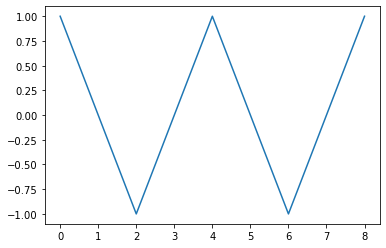

In [42]:
"""
Query - heading  reward plot
rotaion angle 90
"""
heading = np.array([0,1,0])
rotationAngle = 90

r_left = np.eye(3)
r_left[0:2,0:2] = np.array([[np.cos(np.deg2rad(rotationAngle)),-np.sin(np.deg2rad(rotationAngle))],[np.sin(np.deg2rad(rotationAngle)),np.cos(np.deg2rad(rotationAngle))]])
r_right = np.eye(3)
r_right[0:2,0:2] = np.array([[np.cos(np.deg2rad(-rotationAngle)),-np.sin(np.deg2rad(-rotationAngle))],[np.sin(np.deg2rad(-rotationAngle)),np.cos(np.deg2rad(-rotationAngle))]])
  


#
#heading = np.matmul(r_right,heading)
y = list()
x = list()

for i in range(9):
    y.append(heading[1])
    x.append(i)
    heading = np.matmul(r_left,heading)
    
plt.plot(x, y);
print(heading)  

In [ ]:
"""
North Edge - env
"""

In [ ]:
"""
RNN - agent 
"""

In [ ]:
"""
Vanilla World- 
"""
# Simple script to demonstrate how to use the environment as a black box.

# Import the environment
import envV2 as ENV
#Import agent + policy model : Reinforce
from Reinforce_keras import Agent
# other dependencies
import matplotlib.pyplot as plt
import numpy as np

#Load the environment, it has a number of variables that can be initailized.
#Here we just set the movement speed of the drone and drone size radius.
env = ENV.sonarEnv(speed=0.5,dronesize=0.1)

agent = Agent(ALPHA=0.0005, input_dims=10003, GAMMA=0.99,n_actions=4,
             layer1_size=64, layer2_size=64)

score_history = []
steps_history = []
stepDirct_history = [0,0,0,0]

#print observation
n_episodes = 1000
   
for i in range(n_episodes):
    done=False
    score = 0
    steps=0
    observation = env.reset()
    #env.setPrefAction()
    #prefActionEp.append(env.getPrefAction)
    
    while not done and steps < 500:
        #input: get G for profomance - array len episode save G zero
        action = agent.choose_action(observation)
        
        #next steps: 
        # - Reward shaping and obstical avoidance
        # - model shaping based off input shape (Fourier series of tree echo's) 
        #   might filter input audio to make differences stand out 
        #   Qu: what differece are there in audio coming from 
        #       the front vs the back vs the sides?
        # - Qu: What range of directions does the echo inout come from?
        stepDirct_history[action] += 1
            
        #TODO: 
        # add heading 
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward)
        observation = observation_
        score += reward
        steps += 1
        # Render will plot the state as a curve, and also plots a top down plot of the trees
        env.render(steps)
        
    #stores the values of step for graphing
    score_history.append(score)
    steps_history.append(steps)
    
   
    
    agent.learn()
    
    print('episode: ', i, 'score %.1f:' % score,'steps %.1f:' % (steps-1),
          'average_score %.1f:' % np.mean(score_history[-100:]))
agent.save_model()

plt.plot(score_history[:25:])
#plt.plot(steps_history[:25:])
plt.plot(stepDirct_history[:])
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#act = [0,1,2,3]
#ax.bar(act, stepDirct_history[0:4])
plt.show()
# Frees some memory when finished with the environment
env.close()

In [ ]:
"""
[Inputs,Compass_heading] - agent
"""
# Simple script to demonstrate how to use the environment as a black box.

# Import the environment
import envV2 as ENV
#Import agent + policy model : Reinforce
from Reinforce_keras import Agent
# other dependencies
import matplotlib.pyplot as plt
import numpy as np

#Load the environment, it has a number of variables that can be initailized.
#Here we just set the movement speed of the drone and drone size radius.
env = ENV.sonarEnv(speed=0.5,dronesize=0.1)

agent = Agent(ALPHA=0.0005, input_dims=10003, GAMMA=0.99,n_actions=4,
             layer1_size=64, layer2_size=64)

score_history = []
steps_history = []
stepDirct_history = [0,0,0,0]

#print observation
n_episodes = 1000
   
for i in range(n_episodes):
    done=False
    score = 0
    steps=0
    observation = env.reset()
    #env.setPrefAction()
    #prefActionEp.append(env.getPrefAction)
    
    while not done and steps < 500:
        #input: get G for profomance - array len episode save G zero
        action = agent.choose_action(observation)
        
        #next steps: 
        # - Reward shaping and obstical avoidance
        # - model shaping based off input shape (Fourier series of tree echo's) 
        #   might filter input audio to make differences stand out 
        #   Qu: what differece are there in audio coming from 
        #       the front vs the back vs the sides?
        # - Qu: What range of directions does the echo inout come from?
        stepDirct_history[action] += 1
            
        #TODO: 
        # add heading 
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward)
        observation = observation_
        score += reward
        steps += 1
        # Render will plot the state as a curve, and also plots a top down plot of the trees
        env.render(steps)
        
    #stores the values of step for graphing
    score_history.append(score)
    steps_history.append(steps)
    
   
    
    agent.learn()
    
    print('episode: ', i, 'score %.1f:' % score,'steps %.1f:' % (steps-1),
          'average_score %.1f:' % np.mean(score_history[-100:]))
agent.save_model()

plt.plot(score_history[:25:])
#plt.plot(steps_history[:25:])
plt.plot(stepDirct_history[:])
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#act = [0,1,2,3]
#ax.bar(act, stepDirct_history[0:4])
plt.show()
# Frees some memory when finished with the environment
env.close()

In [ ]:
"""
Path Construction - agent
"""
# Simple script to demonstrate how to use the environment as a black box.

# Import the environment
import envV2 as ENV
#Import agent + policy model : Reinforce
from Reinforce_keras import Agent
# other dependencies
import matplotlib.pyplot as plt
import numpy as np

#Load the environment, it has a number of variables that can be initailized.
#Here we just set the movement speed of the drone and drone size radius.
env = ENV.sonarEnv(speed=0.5,dronesize=0.1)

agent = Agent(ALPHA=0.0005, input_dims=10003, GAMMA=0.99,n_actions=4,
             layer1_size=64, layer2_size=64)

score_history = []
steps_history = []
stepDirct_history = [0,0,0,0]

#print observation
n_episodes = 1000
   
for i in range(n_episodes):
    done=False
    score = 0
    steps=0
    observation = env.reset()
    #env.setPrefAction()
    #prefActionEp.append(env.getPrefAction)
    
    while not done and steps < 500:
        #input: get G for profomance - array len episode save G zero
        action = agent.choose_action(observation)
        
        #next steps: 
        # - Reward shaping and obstical avoidance
        # - model shaping based off input shape (Fourier series of tree echo's) 
        #   might filter input audio to make differences stand out 
        #   Qu: what differece are there in audio coming from 
        #       the front vs the back vs the sides?
        # - Qu: What range of directions does the echo inout come from?
        stepDirct_history[action] += 1
            
        #TODO: 
        # add heading 
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward)
        observation = observation_
        score += reward
        steps += 1
        # Render will plot the state as a curve, and also plots a top down plot of the trees
        env.render(steps)
        
    #stores the values of step for graphing
    score_history.append(score)
    steps_history.append(steps)
    
   
    agent.learn()
    
    print('episode: ', i, 'score %.1f:' % score,'steps %.1f:' % (steps-1),
          'average_score %.1f:' % np.mean(score_history[-100:]))
agent.save_model()

plt.plot(score_history[:25:])
#plt.plot(steps_history[:25:])
plt.plot(stepDirct_history[:])
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#act = [0,1,2,3]
#ax.bar(act, stepDirct_history[0:4])
plt.show()
# Frees some memory when finished with the environment
env.close()
